In [1]:
%pip install qiskit==1.2.4
%pip install qiskit-aer==0.15.1
%pip install pylatexenc==2.10


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


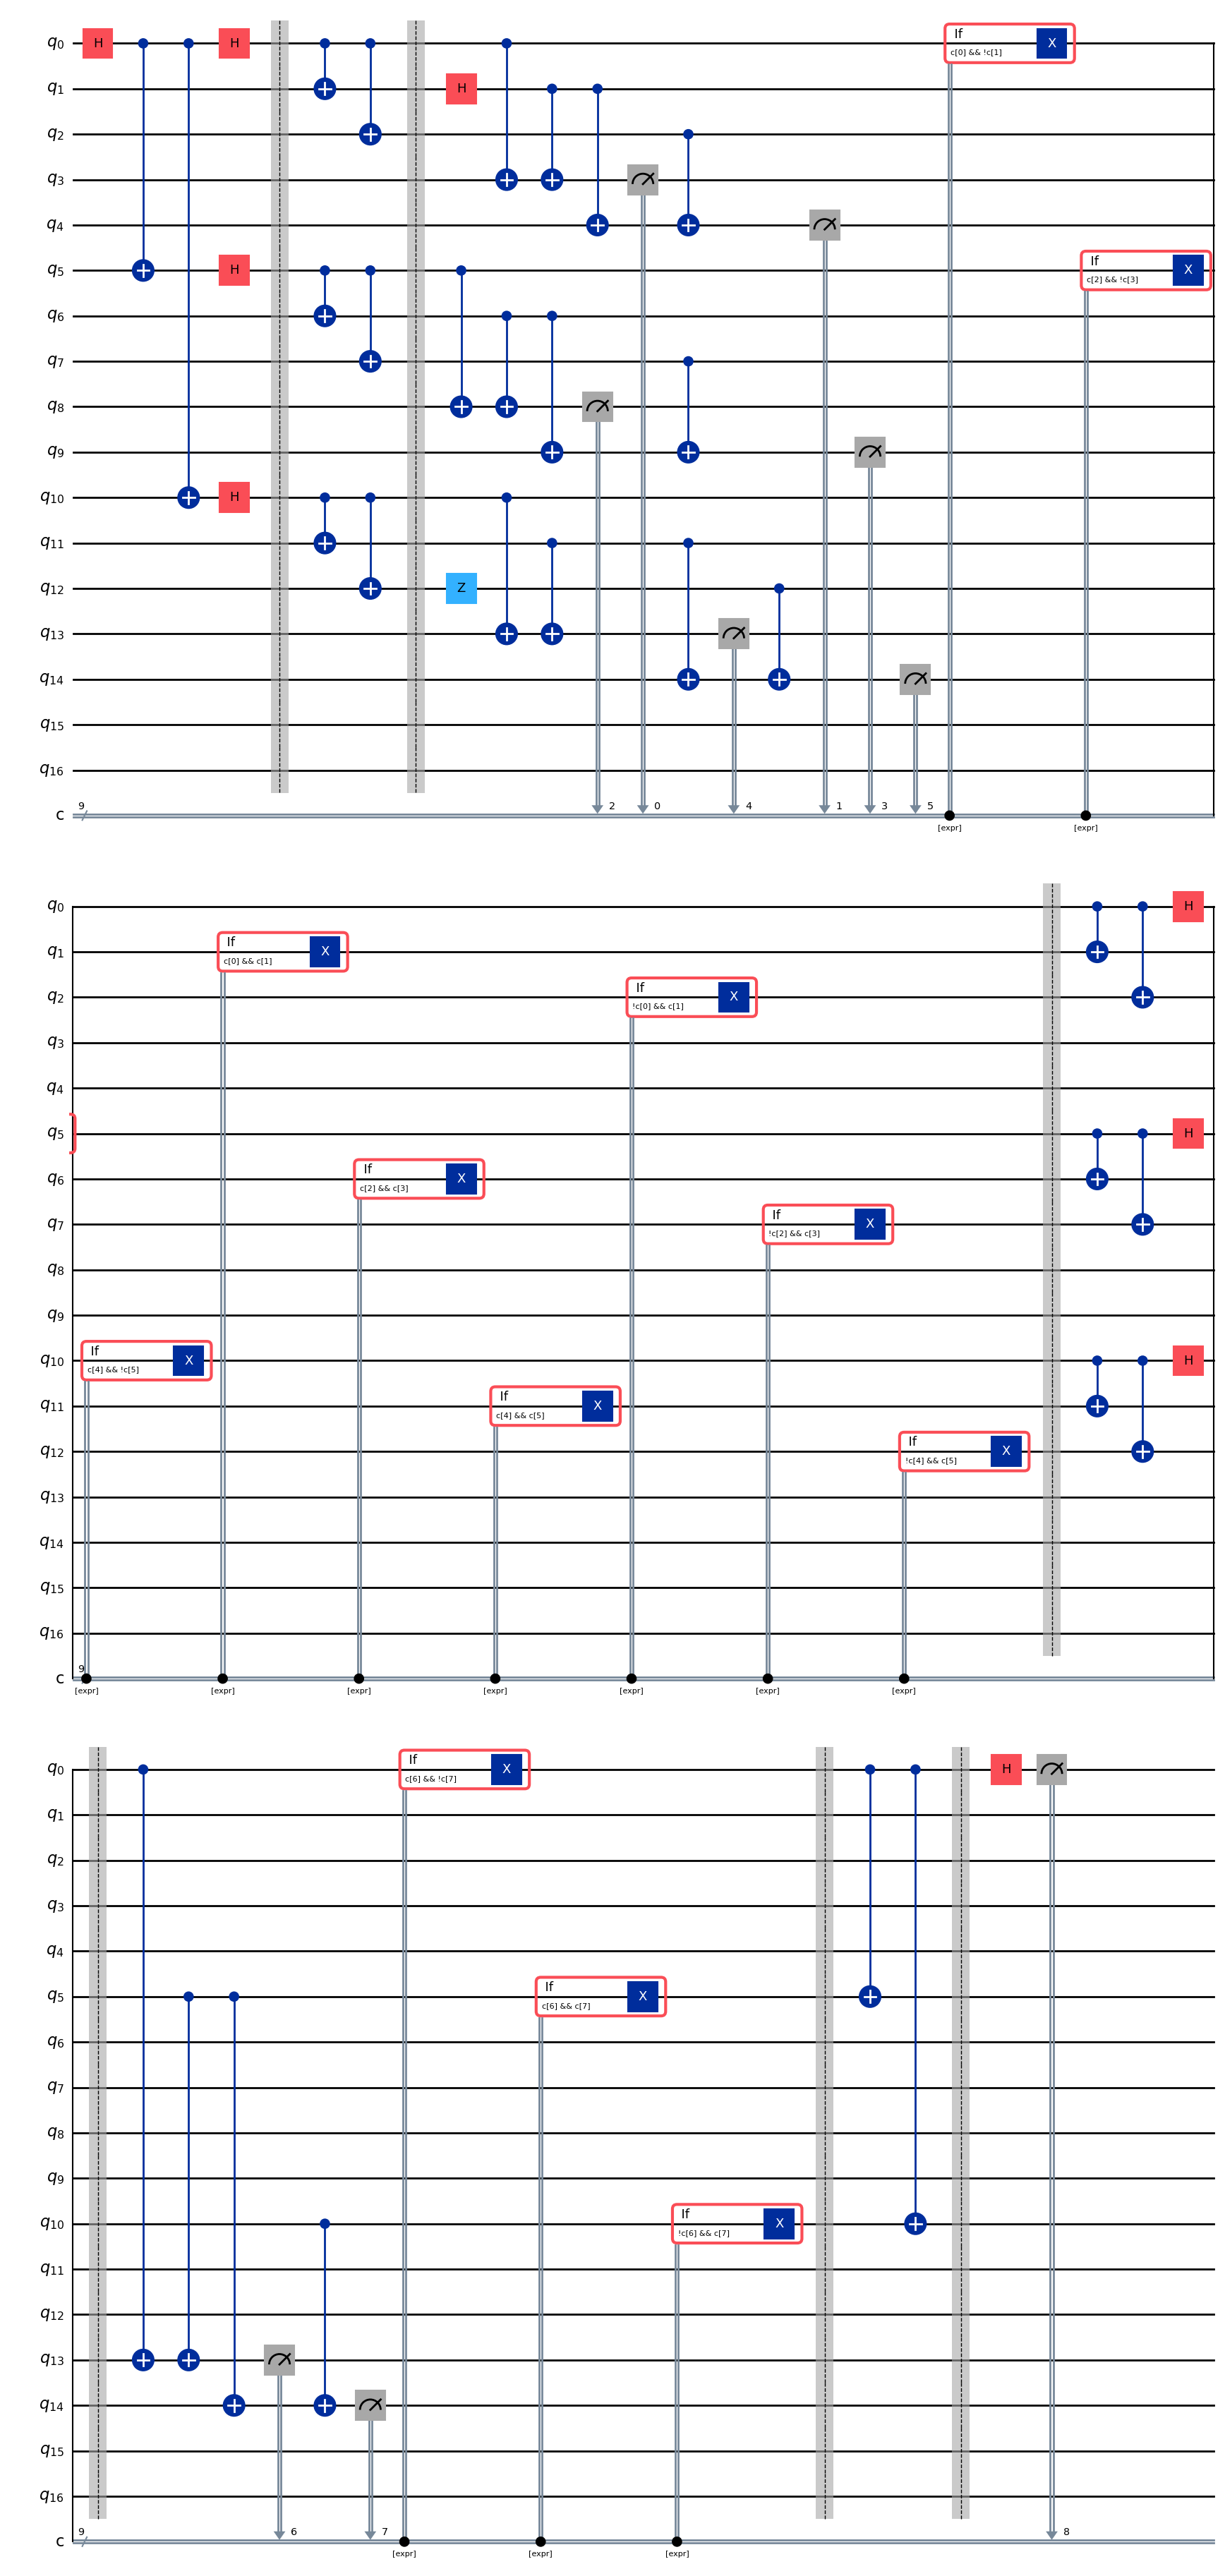

In [13]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_gate
from qiskit.visualization import array_to_latex
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Statevector
from qiskit import transpile 
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_counts
from qiskit.circuit import ControlledGate
from qiskit.circuit.classical import expr
import math 

# Shor code

# The qubit we are encoding is at index 0.
# First there is a phase-flip encoding into three qubits, which will be 0, 5 and 10.
# Then there is a bit-flip encoding of each of those qubits.
# To encode qubit 0 we use qubits 0, 1 and 2.
# To encode qubit 5 we use qubits 5, 6 and 7.
# To encode qubit 10 we use qubits 10, 11 and 12.

# Error correction starts with syndrome measurement on each block of 3 qubits, using 2 ancilla
# qubits each time.
# For syndrome measurement on qubits 0, 1, 2 we use qubits 3 and 4 as ancillas.
# For syndrome measurement on qubits 5, 6, 7 we use qubits 8 and 9 as ancillas.
# For syndrome measurement on qubits 10, 11, 12 we use qubits 13 and 14 as ancillas.

# Then there is a syndrome measurement on qubits 0, 5, 10, for which we use qubits 15 and 16 
# as ancillas.

# Each syndrome measurement needs 2 classical bits, making 8 in all.
# Finally we need 1 more classical bit for the results of a measurement to check that we get
# back to the original state.

# It would be possible to reduce the number of qubits and bits by reusing the ancillas 
# and result bits after each syndrome measurement, but let's keep it simple and clear.

# Also the code could be shortened by defining functions for repeated sections, but this
# version is as direct and simple as possible.

shor = QuantumCircuit(17,9)

# Put qubit 0 into state |+>. At the end we will measure in the diagonal basis.

shor.h(0)

# Phase-flip encoding onto qubits 0, 5, 10

shor.cx(0,5) 
shor.cx(0,10) 
shor.h(0) 
shor.h(5) 
shor.h(10) 

shor.barrier()

# Bit-flip encoding three times

# First qubit 0

shor.cx(0,1) 
shor.cx(0,2) 

# Then qubit 5

shor.cx(5,6) 
shor.cx(5,7) 

# Then qubit 10

shor.cx(10,11) 
shor.cx(10,12) 

shor.barrier()  

# Now we can apply an error to any of qubits 0, 1, 2, 5, 6, 7, 10, 11, 12
# In fact we can apply up to one error in each group of 3 qubits.

shor.h(1) 
shor.z(12) 

# For each group of 3 qubits, do the syndrome measurement and error correction in the same
# way as for the bit-flip code.

# Qubits 0, 1, 2

shor.cx(0,3) 
shor.cx(1,3) 
shor.cx(1,4) 
shor.cx(2,4)
shor.measure([3,4],[0,1])
with shor.if_test(expr.logic_and(shor.clbits[0],expr.logic_not(shor.clbits[1]))): 
    shor.x(0)
with shor.if_test(expr.logic_and(shor.clbits[0],shor.clbits[1])):
    shor.x(1)
with shor.if_test(expr.logic_and(expr.logic_not(shor.clbits[0]),shor.clbits[1])): 
    shor.x(2)

# Qubits 5, 6, 7

shor.cx(5,8) 
shor.cx(6,8) 
shor.cx(6,9) 
shor.cx(7,9)
shor.measure([8,9],[2,3])
with shor.if_test(expr.logic_and(shor.clbits[2],expr.logic_not(shor.clbits[3]))): 
    shor.x(5)
with shor.if_test(expr.logic_and(shor.clbits[2],shor.clbits[3])):
    shor.x(6)
with shor.if_test(expr.logic_and(expr.logic_not(shor.clbits[2]),shor.clbits[3])): 
    shor.x(7)

# Qubits 10, 11, 12

shor.cx(10,13) 
shor.cx(11,13) 
shor.cx(11,14) 
shor.cx(12,14)
shor.measure([13,14],[4,5])
with shor.if_test(expr.logic_and(shor.clbits[4],expr.logic_not(shor.clbits[5]))): 
    shor.x(10)
with shor.if_test(expr.logic_and(shor.clbits[4],shor.clbits[5])):
    shor.x(11)
with shor.if_test(expr.logic_and(expr.logic_not(shor.clbits[4]),shor.clbits[5])): 
    shor.x(12)

shor.barrier() 

# Now undo the bit-flip encoding in each group of 3 qubits, and apply H

# Qubits 0, 1, 2

shor.cx(0,1) 
shor.cx(0,2) 
shor.h(0) 

# Qubits 5, 6, 7

shor.cx(5,6) 
shor.cx(5,7) 
shor.h(5) 

# Qubits 10, 11, 12

shor.cx(10,11) 
shor.cx(10,12) 
shor.h(10) 

shor.barrier() 

# Now the syndrome measurement on qubits 0, 5, 10, and error correction

shor.cx(0,13) 
shor.cx(5,13) 
shor.cx(5,14) 
shor.cx(10,14)
shor.measure([13,14],[6,7])
with shor.if_test(expr.logic_and(shor.clbits[6],expr.logic_not(shor.clbits[7]))): 
    shor.x(0)
with shor.if_test(expr.logic_and(shor.clbits[6],shor.clbits[7])):
    shor.x(5)
with shor.if_test(expr.logic_and(expr.logic_not(shor.clbits[6]),shor.clbits[7])): 
    shor.x(10)

shor.barrier() 

# Undo the encoding to get back to qubit 0 in its original state

shor.cx(0,5) 
shor.cx(0,10) 

shor.barrier() 

# Measure qubit 0 in the diagonal basis. We are looking for a consistent result of 0

shor.h(0) 
shor.measure([0],[8]) 

# Check the circuit

shor.draw("mpl")

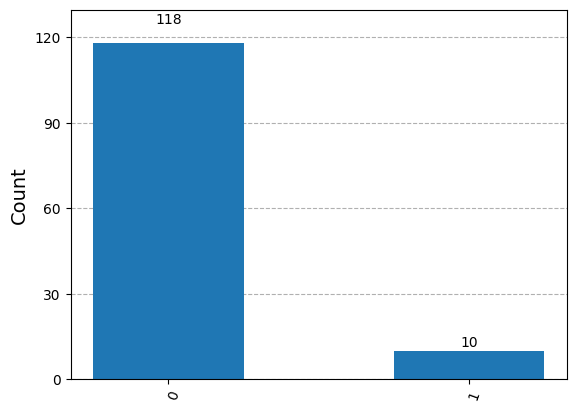

In [14]:
# Simulate and plot results

backend = GenericBackendV2(num_qubits=17, control_flow=True)
compiled = transpile(shor, backend)
job_sim = backend.run(compiled, shots=128)
result_sim = job_sim.result()
counts = result_sim.get_counts(compiled)
# We only want to see the results for bit 8
mcounts = marginal_counts(counts,indices=[8]) 
plot_histogram(mcounts)